# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Structured Streaming** </center>
---

**Date**: November, 2025

**Student Name**: Luis Adrian Bravo Ramirez

**Professor**: Pablo Camarillo Ramirez

---

# Objective
To build a data pipeline in Python using Apache Spark for data consumption in continuous mode, transformation, and persistence, with the objective of addressing a practical problem. 

---


# Producer

The producer is a Python script that will generate information in continuous mode, specifically information related to the _twitch gamers_ dataset. This script will generate random information, like the following:

```bash
"numeric_id": 83382684,
"views": 303579,
"mature": true,
"life_time": 137,
"created_at": "2010-05-17",
"updated_at": "2010-10-01",
"dead_account": true,
"language": "DE",
"affiliate": true,
"activity_status": "Inactive",
"account_category": "Mega"
```


## Command Line Arguments
The producer requires two arguments:
```bash
python3 producer_script_luis_bravo.py  
```
- `<broker>`: Kafka broker address (`kafka:9093`)

- `<topic>`: Kafka topic name to publish messages to

## Creating topic

As we said, the producer requires a topic. To create it, execute the following command that will create a topic called _*streaming_processing_luisbravo*_.

```bash
docker exec -it <kafka_container_id> \
/opt/kafka/bin/kafka-topics.sh \
--create --zookeeper zookeeper:2181 \
--replication-factor 1 --partitions 1 \
--topic streaming_processing_luisbravo
```

NOTE: You must use your Kafka Container ID on <kafka_container_id>.

## Testing from Jupyter Notebook
To test the producer, you must open the Jupyter Notebook on your Web Browser and do the following :
- Select _File > New > Terminal_

- Access to my folder which is _/opt/spark/work-dir/lib/luisbravor00_ using a `cd /opt/spark/work-dir/lib/luisbravor00`

- Execute `python3 producer_script_luis_bravo.py kafka:9093 streaming_processing_luisbravo` to start the producer

This producer uses Kafka as the message broker to simulate real-time streaming data ingestion for analytics and processing pipelines. The consumer must be running before executing the producer to get all the data created by it.

*NOTE*: I configured my Producer to iterate 100 times, so I can have a 100 records in total (so I can have more information to work with). 

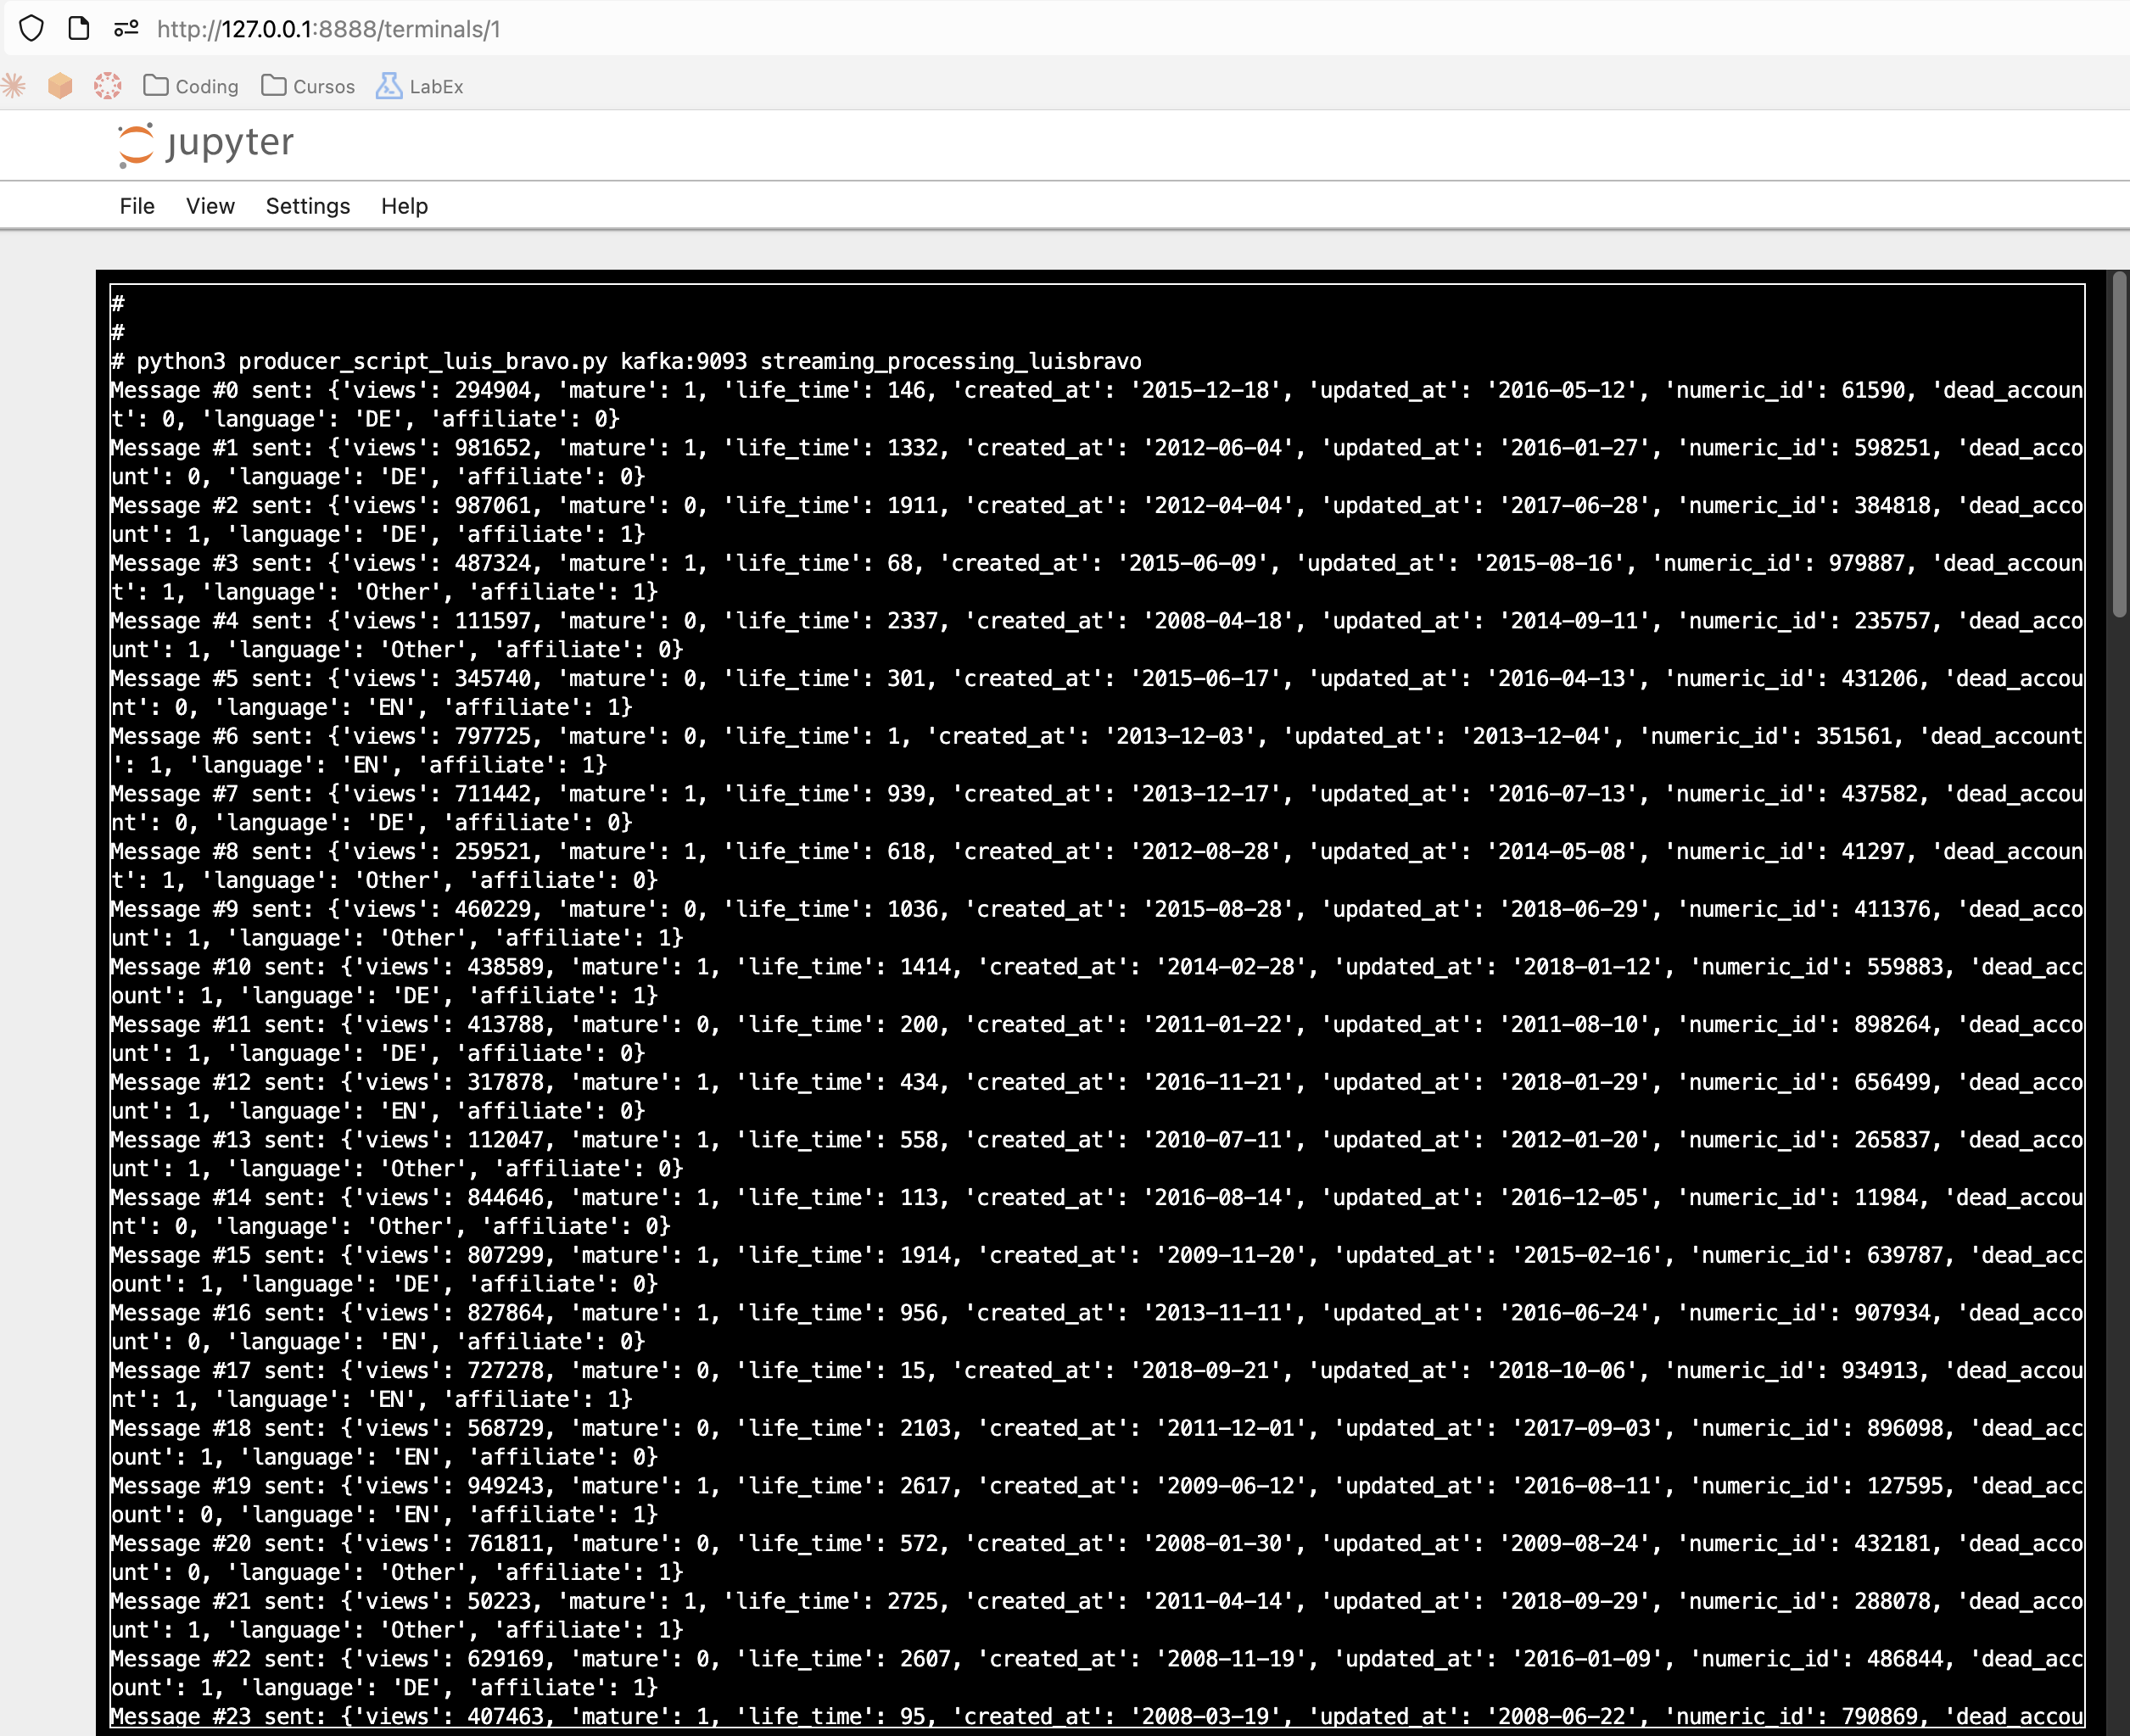

---

# Consumer

### Create Spark Session

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Structured Streaming: Twitch Gamers") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.13:4.0.0") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("INFO")

# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.apache.spark#spark-sql-kafka-0-10_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7bf6c93c-33d8-4684-93bb-c6b38c7a51bd;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.13;4.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.13;4.0.0 in central
	found org.apache.kafka#kafka-clients;3.9.0 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.7 in central
	found org.slf4j#slf4j-api;2.0.16 in central
	found org.apache.hadoop#hadoop-client-runtime;3.4.1 in central
	found org.apache.hadoop#hadoop-client-api;3.4.1 in central
	found com.google.code.findbugs#jsr305;3.0.0 in central
	found org.scala-lang.modules#scala-parallel-collections_2.13;1.2.0

---

## Dataset and Stream creation

### Create the remote connection to Kafka

*REMINDER*: Create the topic before running the following cell. \

`docker exec -it 776688eed872951b48536248b0cdc3182f813837eb7ebf30deb8162ab5c8cb3c /opt/kafka/bin/kafka-topics.sh --create --zookeeper zookeeper:2181 --replication-factor 1 --partitions 1 --topic streaming_processing_luisbravo`

In [2]:
# Create the remote connection
kafka_df = spark.readStream \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "kafka:9093") \
            .option("subscribe", "streaming_processing_luisbravo") \
            .load()

### Create the schema for the dataset

In [3]:
from luisbravor00.spark_utils import SparkUtils
from pyspark.sql.functions import from_json

ts_telemetry_df = kafka_df.select(kafka_df.value.cast("string").alias("value_str"))

# Extract the columns from the input JSON
schema_columns = [("views", "int"),
                  ("mature", "int"),
                  ("life_time", "int"),
                  ("created_at", "string"),
                  ("updated_at", "string"),
                  ("numeric_id", "int"),
                  ("dead_account", "int"),
                  ("language", "string"),
                  ("affiliate", "int")]
pkg_schema = SparkUtils.generate_schema(schema_columns)
ts_extracted_df = ts_telemetry_df.withColumn("telemetry", from_json(ts_telemetry_df.value_str, pkg_schema))

### Stream

In [ ]:
# Send the stream to a files sink
query_files = ts_extracted_df.writeStream \
                .trigger(processingTime="4 seconds") \
                .format("parquet") \
                .option("header", "true") \
                .option("path", "/opt/spark/work-dir/data/ts_output/") \
                .option("checkpointLocation", "/opt/spark/work-dir/data/ts_checkpoint") \
                .start()

25/11/13 01:22:29 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.


---

## Transformations and Actions

In [5]:
path = "/opt/spark/work-dir/data/ts_output/"

# Read all parquet part files in that folder
df = spark.read.parquet(path)

# Parse the dataframe and get all the information (message sent) from it
df = df.select("telemetry.*")


Now, the transformations (create new columns, aggreate, run joins, etc.) will take place. For this case, we'll execute the following:

1. Remove duplicates using `numeric_id` entries and clean null values (for this quantity of records and due to the randomness of the producer, no repeated records should be found).

2. Convert `mature`, `dead_account`and `affiliate` from integer (0 or 1) to a boolean type (true or false).

3. Parse `created_at`and `updated_at` string into date objects.

4. Make sure that `numeric_id`, `views`, and `life_time` are integers.

5. Add a column called `activity_status` that will categorize the account activity with these values:
    - "Very Active" (updated within 30 days)
    - "Active" (within 90 days)
    - "Less Active" (within 180 days)
    - "Inactive" (no activity)

6. Add a column called `account_category` that will classify the account based on views:
    - "Nano": views < 1,000 (New or very small streamers)
    - "Micro": 1,000 ≤ views < 10,000 (Small but growing audience)
    - "Mid-Tier": 10,000 ≤ views < 50,000 (Established presence)
    - "Macro": 50,000 ≤ views < 100,000 (Significant reach)
    - "Mega": 100,000 ≤ views < 500,000 (High influence)
    - "Elite": views ≥ 500,000 (Top-tier streamers)

7. Trim whitespace from all string fields to avoid any future issues with these fields.

In [6]:
from pyspark.sql.functions import col, trim, when, isnull, count, to_date, max, datediff, lit, desc

In [7]:
# Remove duplicates using numeric_id and clean null values
print(f"Number of records for the dataframe before cleaning: {df.count()}")
df.select([count(when(isnull(c[0]) | col(c[0]).isNull(), c[0])).alias(c[0]) for c in schema_columns]).show()

# Perform data cleaning with trim (column by column)
df_clean = df \
        .dropDuplicates(["numeric_id"]) \
        .filter(col("numeric_id").isNotNull()) \
        .filter(col("views").isNotNull()) \
        .filter(col("mature").isNotNull()) \
        .filter(col("life_time").isNotNull()) \
        .filter(col("dead_account").isNotNull()) \
        .filter(col("affiliate").isNotNull()) \
        .withColumn("created_at", trim("created_at")) \
        .withColumn("updated_at", trim("updated_at")) \
        .withColumn("language", trim("language")) \

# Perform data cleaning with dropna (make sure that it erases null values)
df_clean = df_clean.dropna()
print(f"\nNumber of records for the dataframe after cleaning with trim & dropna: {df_clean.count()}\n")

Number of records for the dataframe before cleaning: 100
+-----+------+---------+----------+----------+----------+------------+--------+---------+
|views|mature|life_time|created_at|updated_at|numeric_id|dead_account|language|affiliate|
+-----+------+---------+----------+----------+----------+------------+--------+---------+
|    0|     0|        0|         0|         0|         0|           0|       0|        0|
+-----+------+---------+----------+----------+----------+------------+--------+---------+


Number of records for the dataframe after cleaning with trim & dropna: 100



In [8]:

# Convert mature, dead_account and affiliate from integer to boolean
df_clean = df_clean \
    .withColumn("mature", col("mature").cast("boolean")) \
    .withColumn("dead_account", col("dead_account").cast("boolean")) \
    .withColumn("affiliate", col("affiliate").cast("boolean"))

In [9]:
# Parse created_at and updated_at string values into date objects
df_clean = df_clean \
    .withColumn("created_at", to_date("created_at")) \
    .withColumn("updated_at", to_date("updated_at"))

* Already checked that `numeric_id`, `views` and `life_time` fields are **integers**.

In [10]:
# Add a columns called activity status that will categorize the account activity using the updated_at field
## Get the latest date from the updated_at column so we can use it as current date
max_date = df_clean.select(max(col("updated_at")).alias("max_date")).collect()[0]["max_date"]

## Add the new column activity_status and compute it's values
df_clean = df_clean.withColumn(
    "activity_status",
    when(datediff(lit(max_date), col("updated_at")) <= 30, "Very Active")
    .when(datediff(lit(max_date), col("updated_at")) <= 90, "Active")
    .when(datediff(lit(max_date), col("updated_at")) <= 180, "Less Active")
    .otherwise("Inactive")
)

In [11]:
# Add a column called account_category that will classify the account based on views column
df_clean = df_clean.withColumn(
    "account_category",
    when(col("views") < 1000, "Starter")
    .when((col("views") >= 1000) & (col("views") < 10000), "Emerging")
    .when((col("views") >= 10000) & (col("views") < 50000), "Established")
    .when((col("views") >= 50000) & (col("views") < 100000), "Popular")
    .when((col("views") >= 100000) & (col("views") < 500000), "Star")
    .otherwise("Legend")
)

---

## Persistence Data

We'll persist this dataframe using two formats:

1. Parquet file with a vertical partition on activity_status column
2. On a CSV file, so we can upload it to PowerBI and create a Dashboard with relevant information about this data.

In [12]:
# Define the base path where the files will be saved
base_path = "/opt/spark/work-dir/data/"

# Save it into a Parquet file using a vertical partition with the acticity status for every streamer
df_clean.write \
    .partitionBy("activity_status") \
    .mode("overwrite") \
    .parquet(base_path + "streaming_processing/output/parquet")   

In [13]:
# Save it into a CSV file so I can use it later for the PowerBI Dashboard
df_clean.write \
    .mode("overwrite") \
    .option("header", True) \
    .csv(base_path + "streaming_processing/output/csv")

---

## PowerBI Dashboard

Now, here is an image for the PowerBI Dashboard created with the imported CSV file on the step before.
The dashbaord shows a lot of information. I'll explain each part:

*Views distribution per Account Category* \
Shows the views distribution for every Account Category showing also if the content they make is for mature only or for all audiences.

*Streamer Language* \
Here, you can select the streamer language you want which are EN, DE, Other or all the languages. This will change the information for all the graphics depending on the option you select.

*Streamer's Activity* \
Shows the distribution of the activity of the streamer depending on the language selection. You can see here if they have been Inactive, Active, Less Active or Very Active on the platform.

*Account Creations per year* \
Shows the distribution for every account creation per year, basically telling us how the "success" or the activity for the platform in general based on how many account creations took place and on what year.

*Streamer's Information* \
This table shows relevant information not shown on other graphics, such as Streamer ID, Life Time, if he or she is affiliated, if the account is dead and the date when the last account update happened.

*Views per Streamer with ID and Language* \
Finally, we have a treemap that shows the views distribution per Streamer (showing the Streamer ID, and Language it you hover on it) so you can get the top streamers of all time. 



For this first image, we'll see all the information for all the languages (EN, DE and Other).


*NOTE*: The information shown on the dashboard can change because of the randomness of the producer, I used an "old" CSV to create the Dashboard, so the information may not be the same as the one generated on the parquet and csv paths. But it is basically the same. 

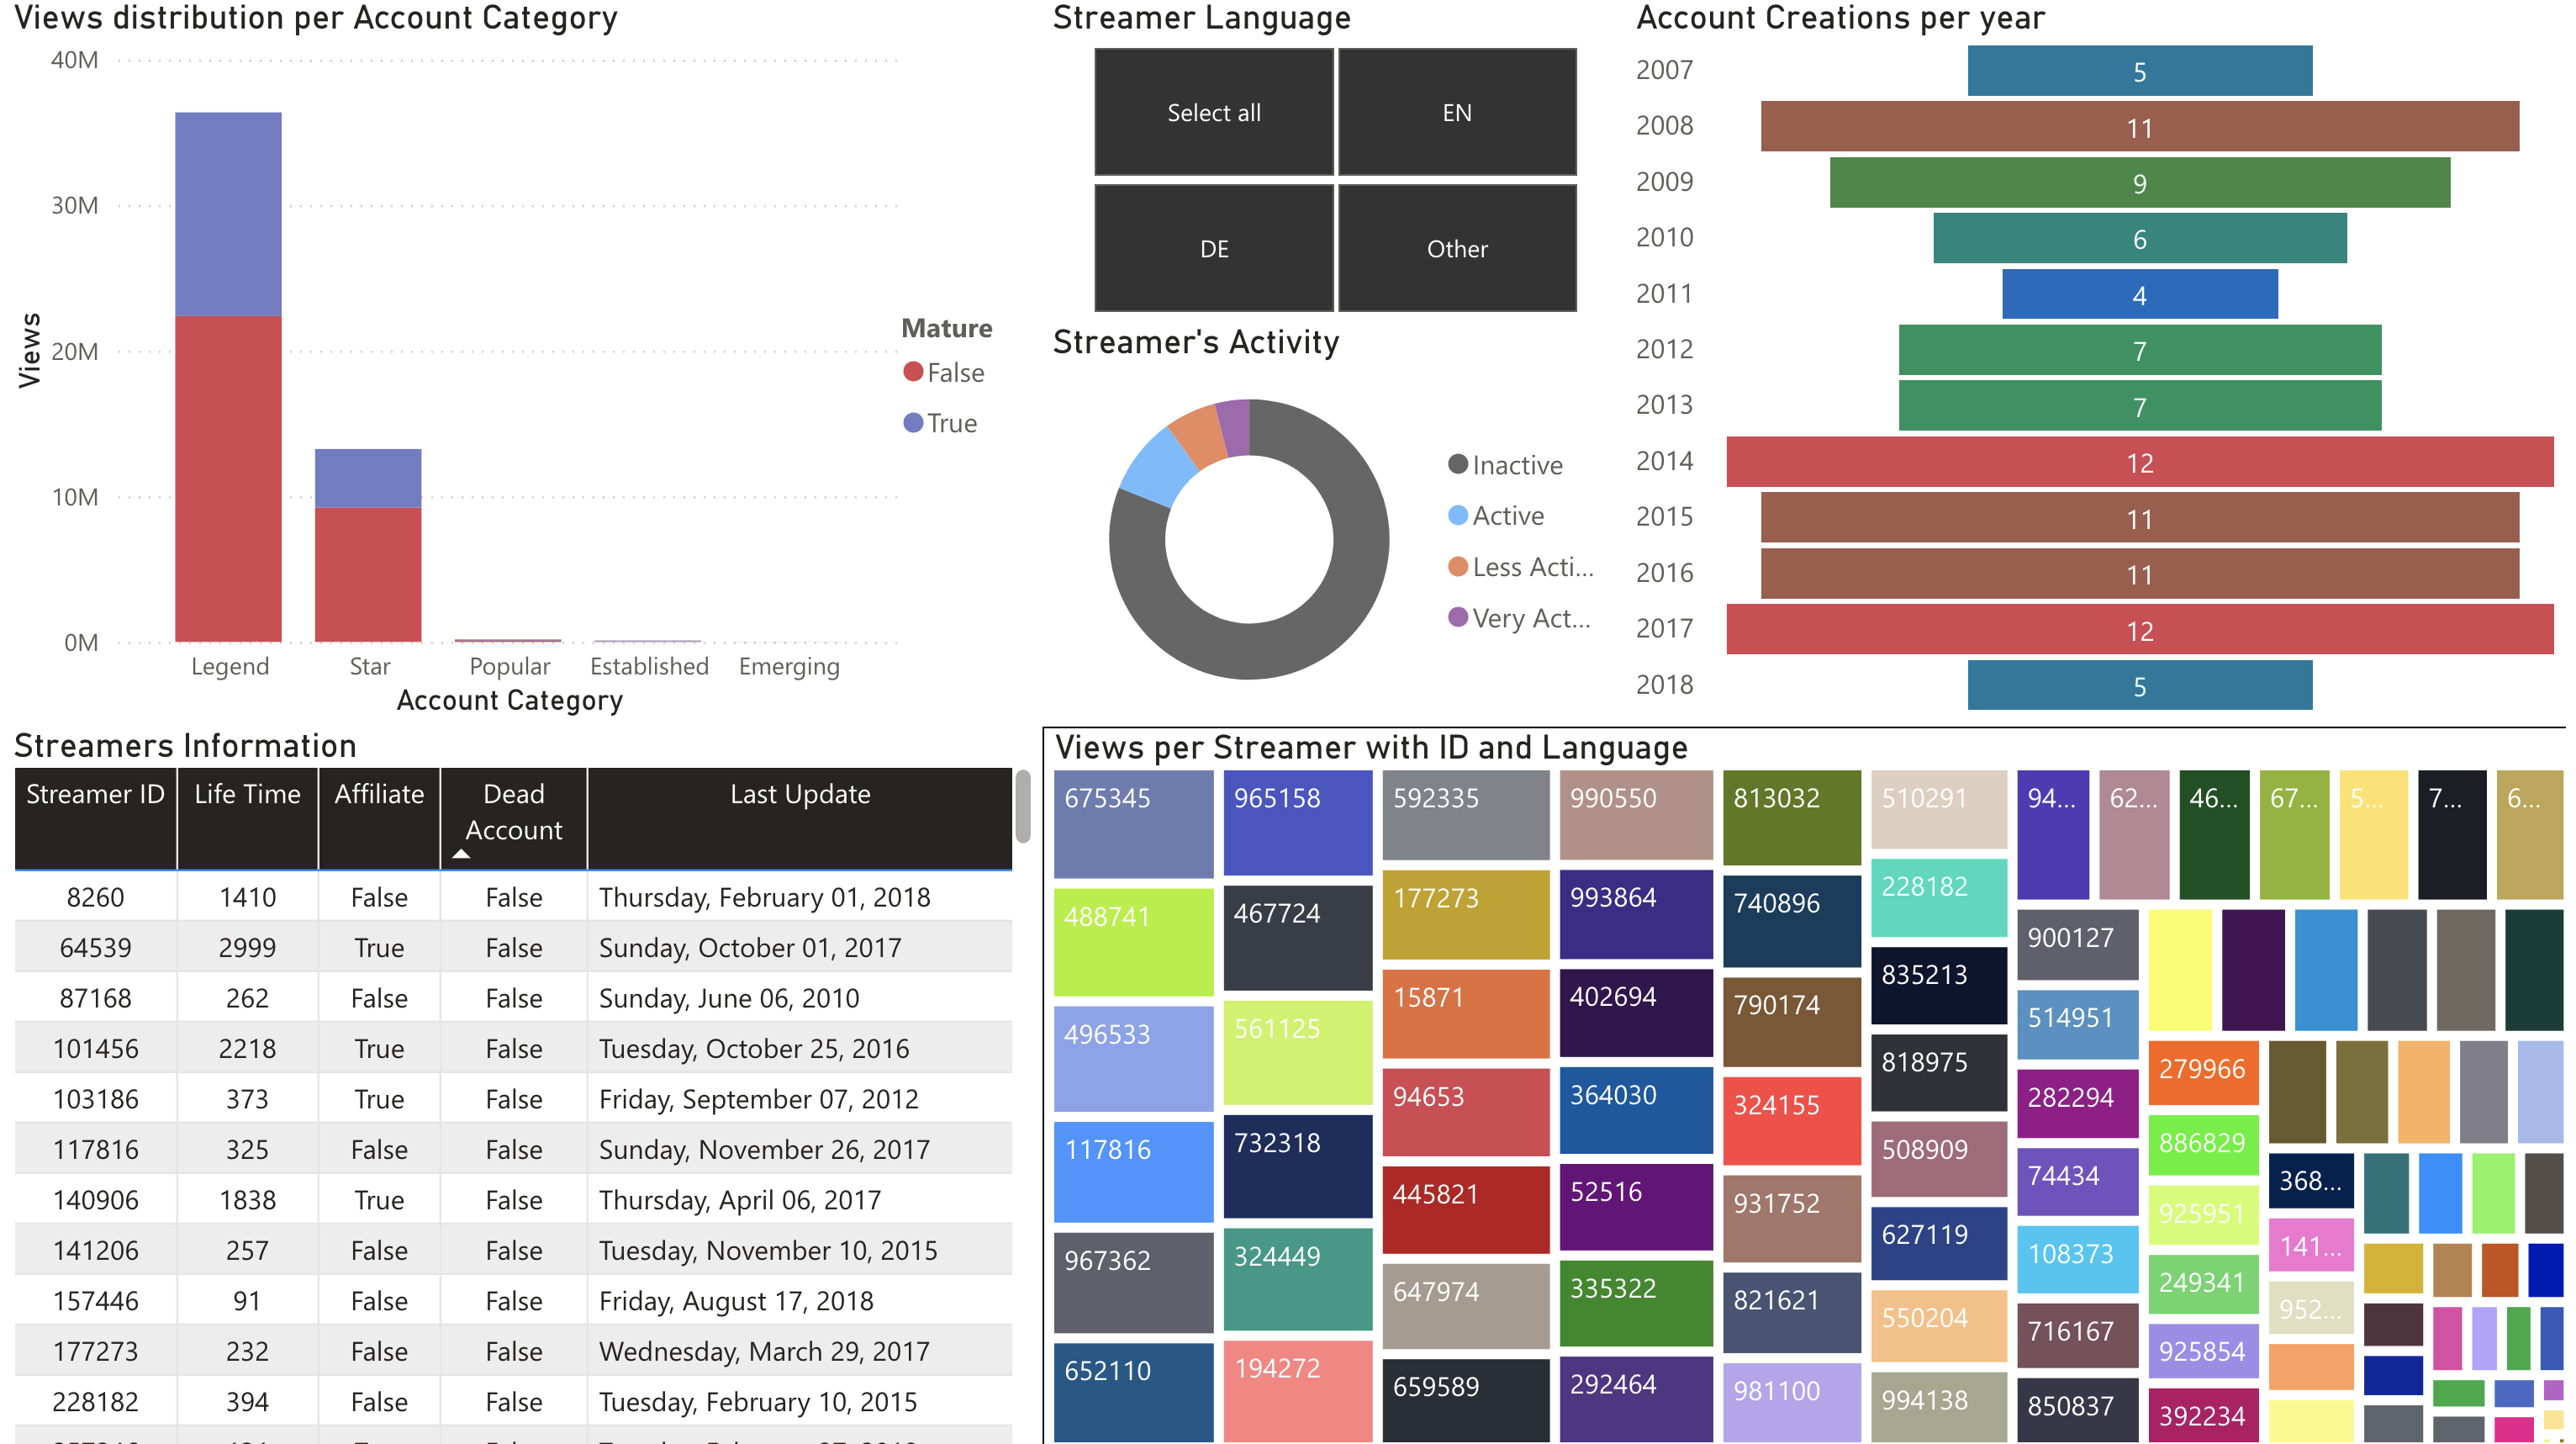

Now, I'll select only the Other language to see the difference between selecting all the languages and just one.



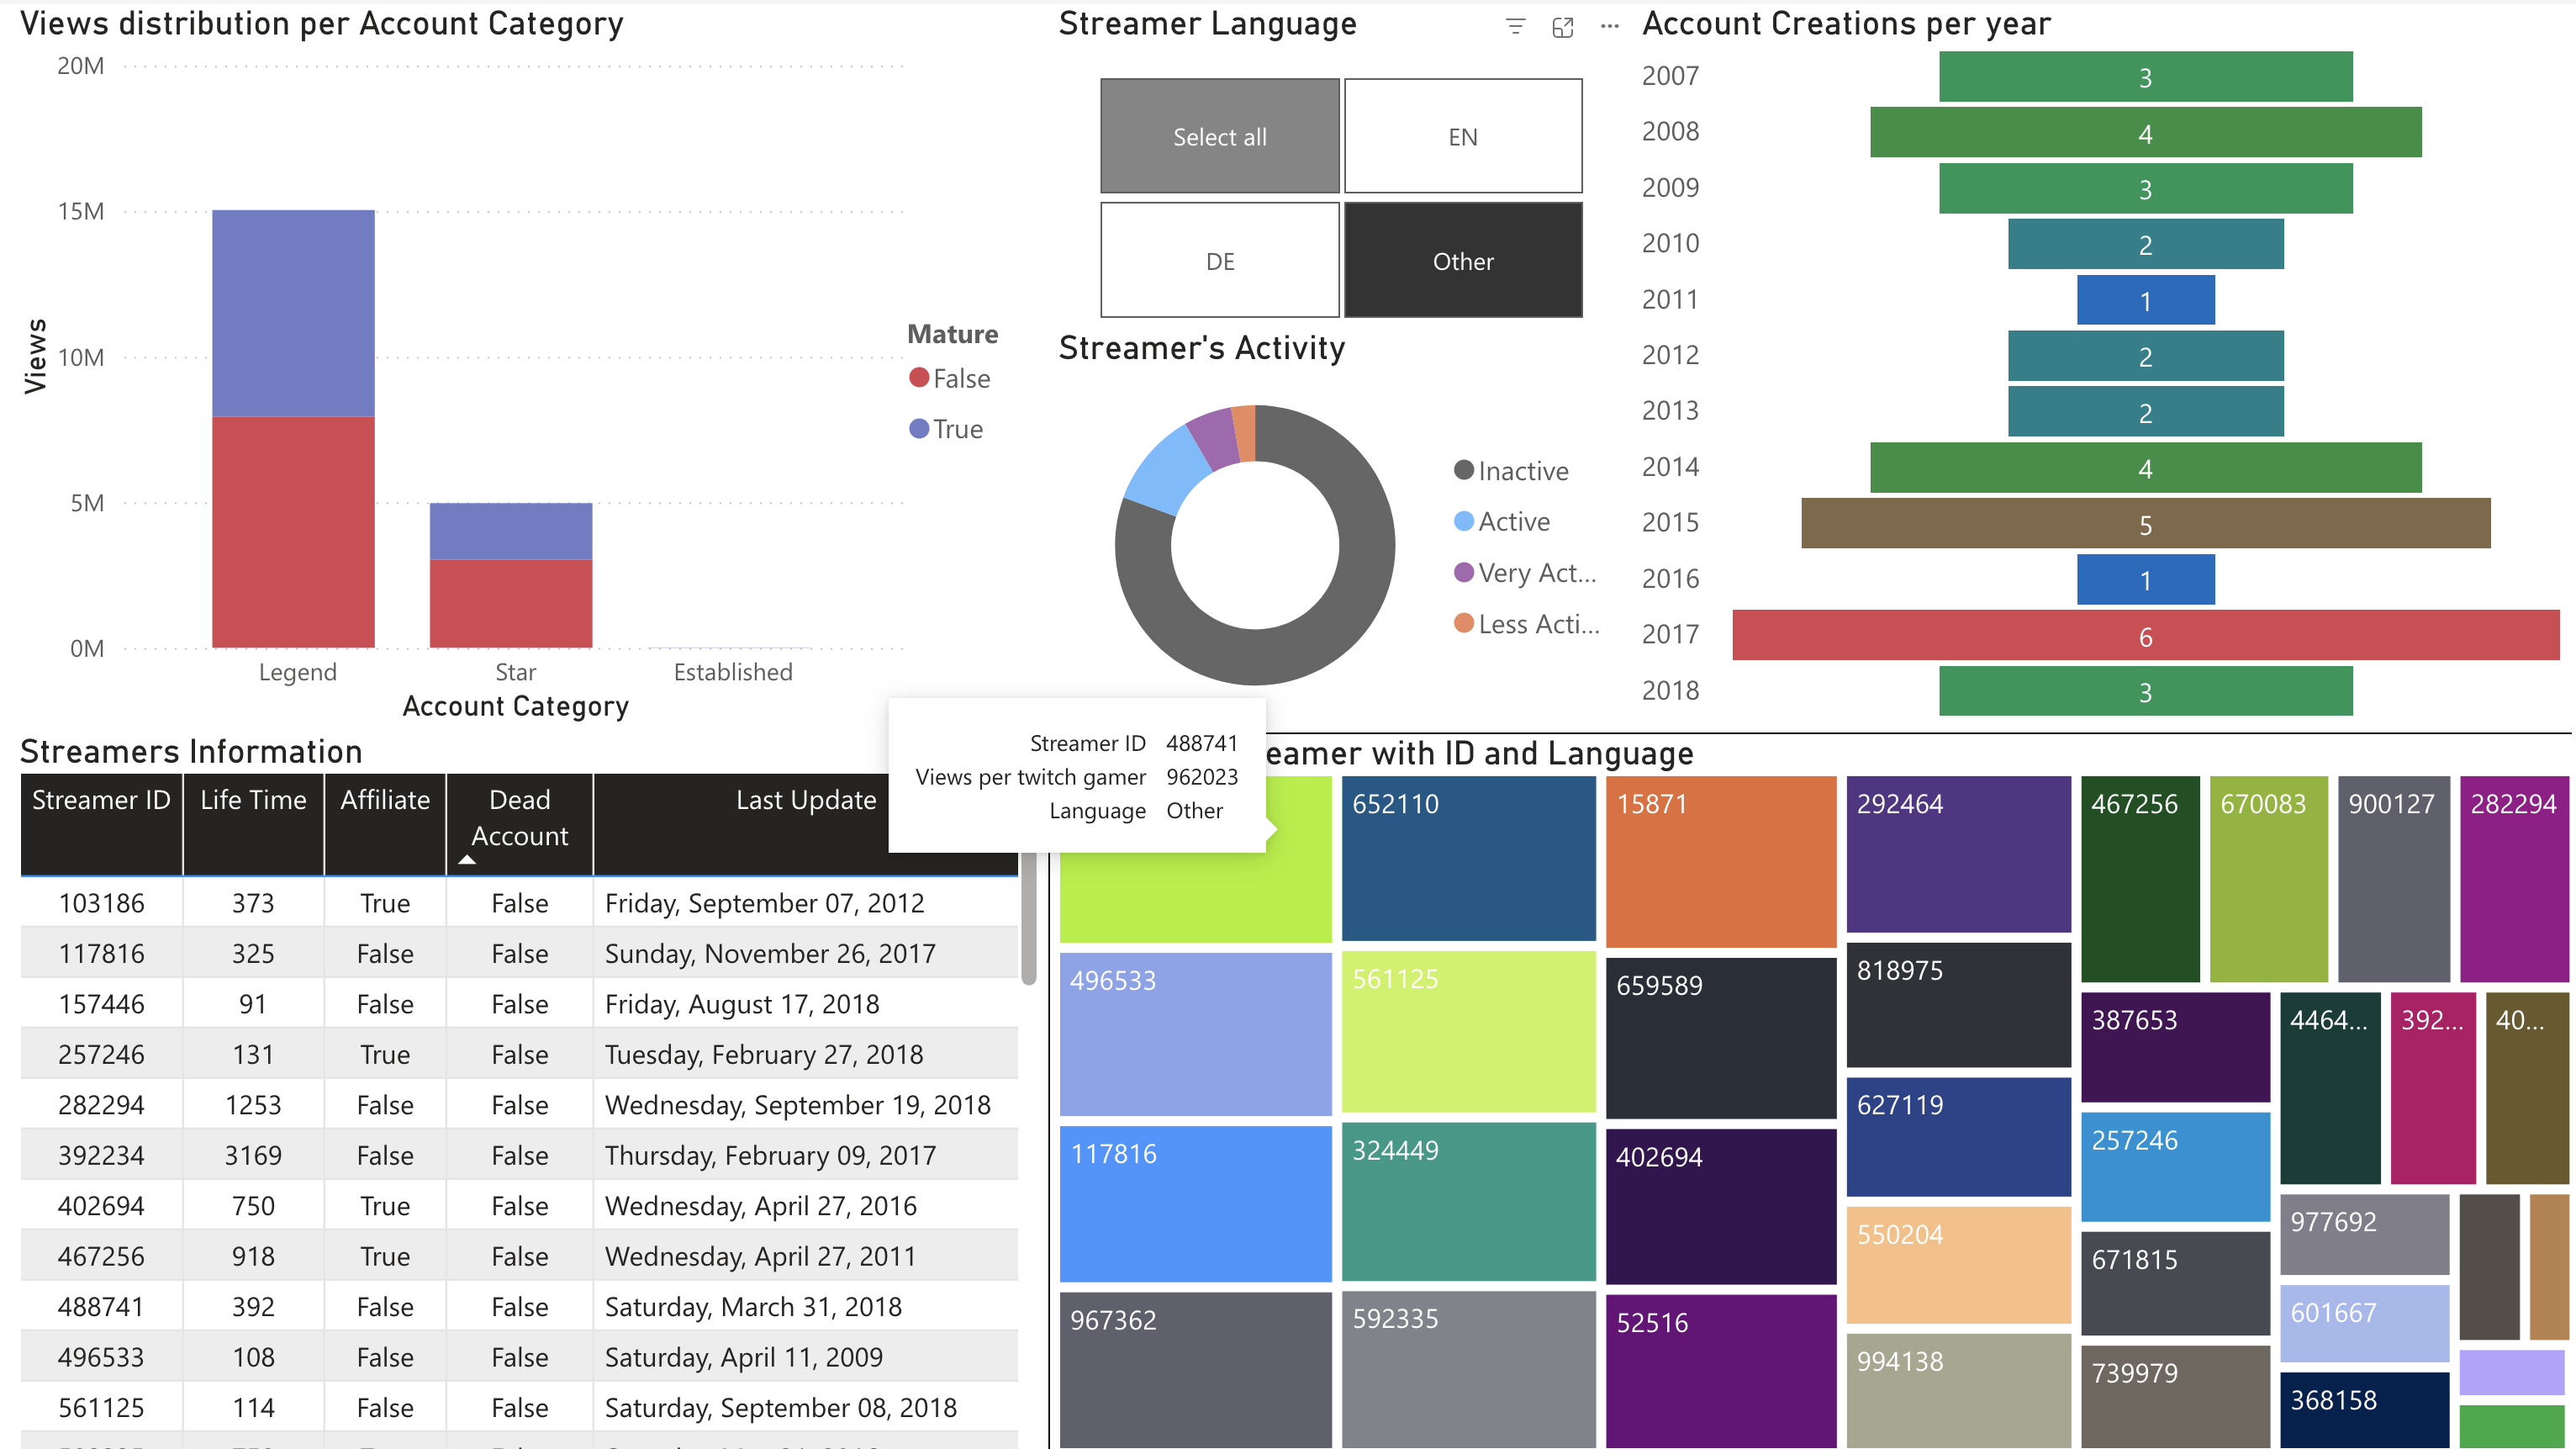

Finally, I'll select a specific streamer from the treemap to se how the values on all the graphics change. I'll also change the Language to DE.

We can see his information on the table, the views he had, when the account was created, it's activity and the type of content he makes (he makes all audiences content and his a "Star" streamer).

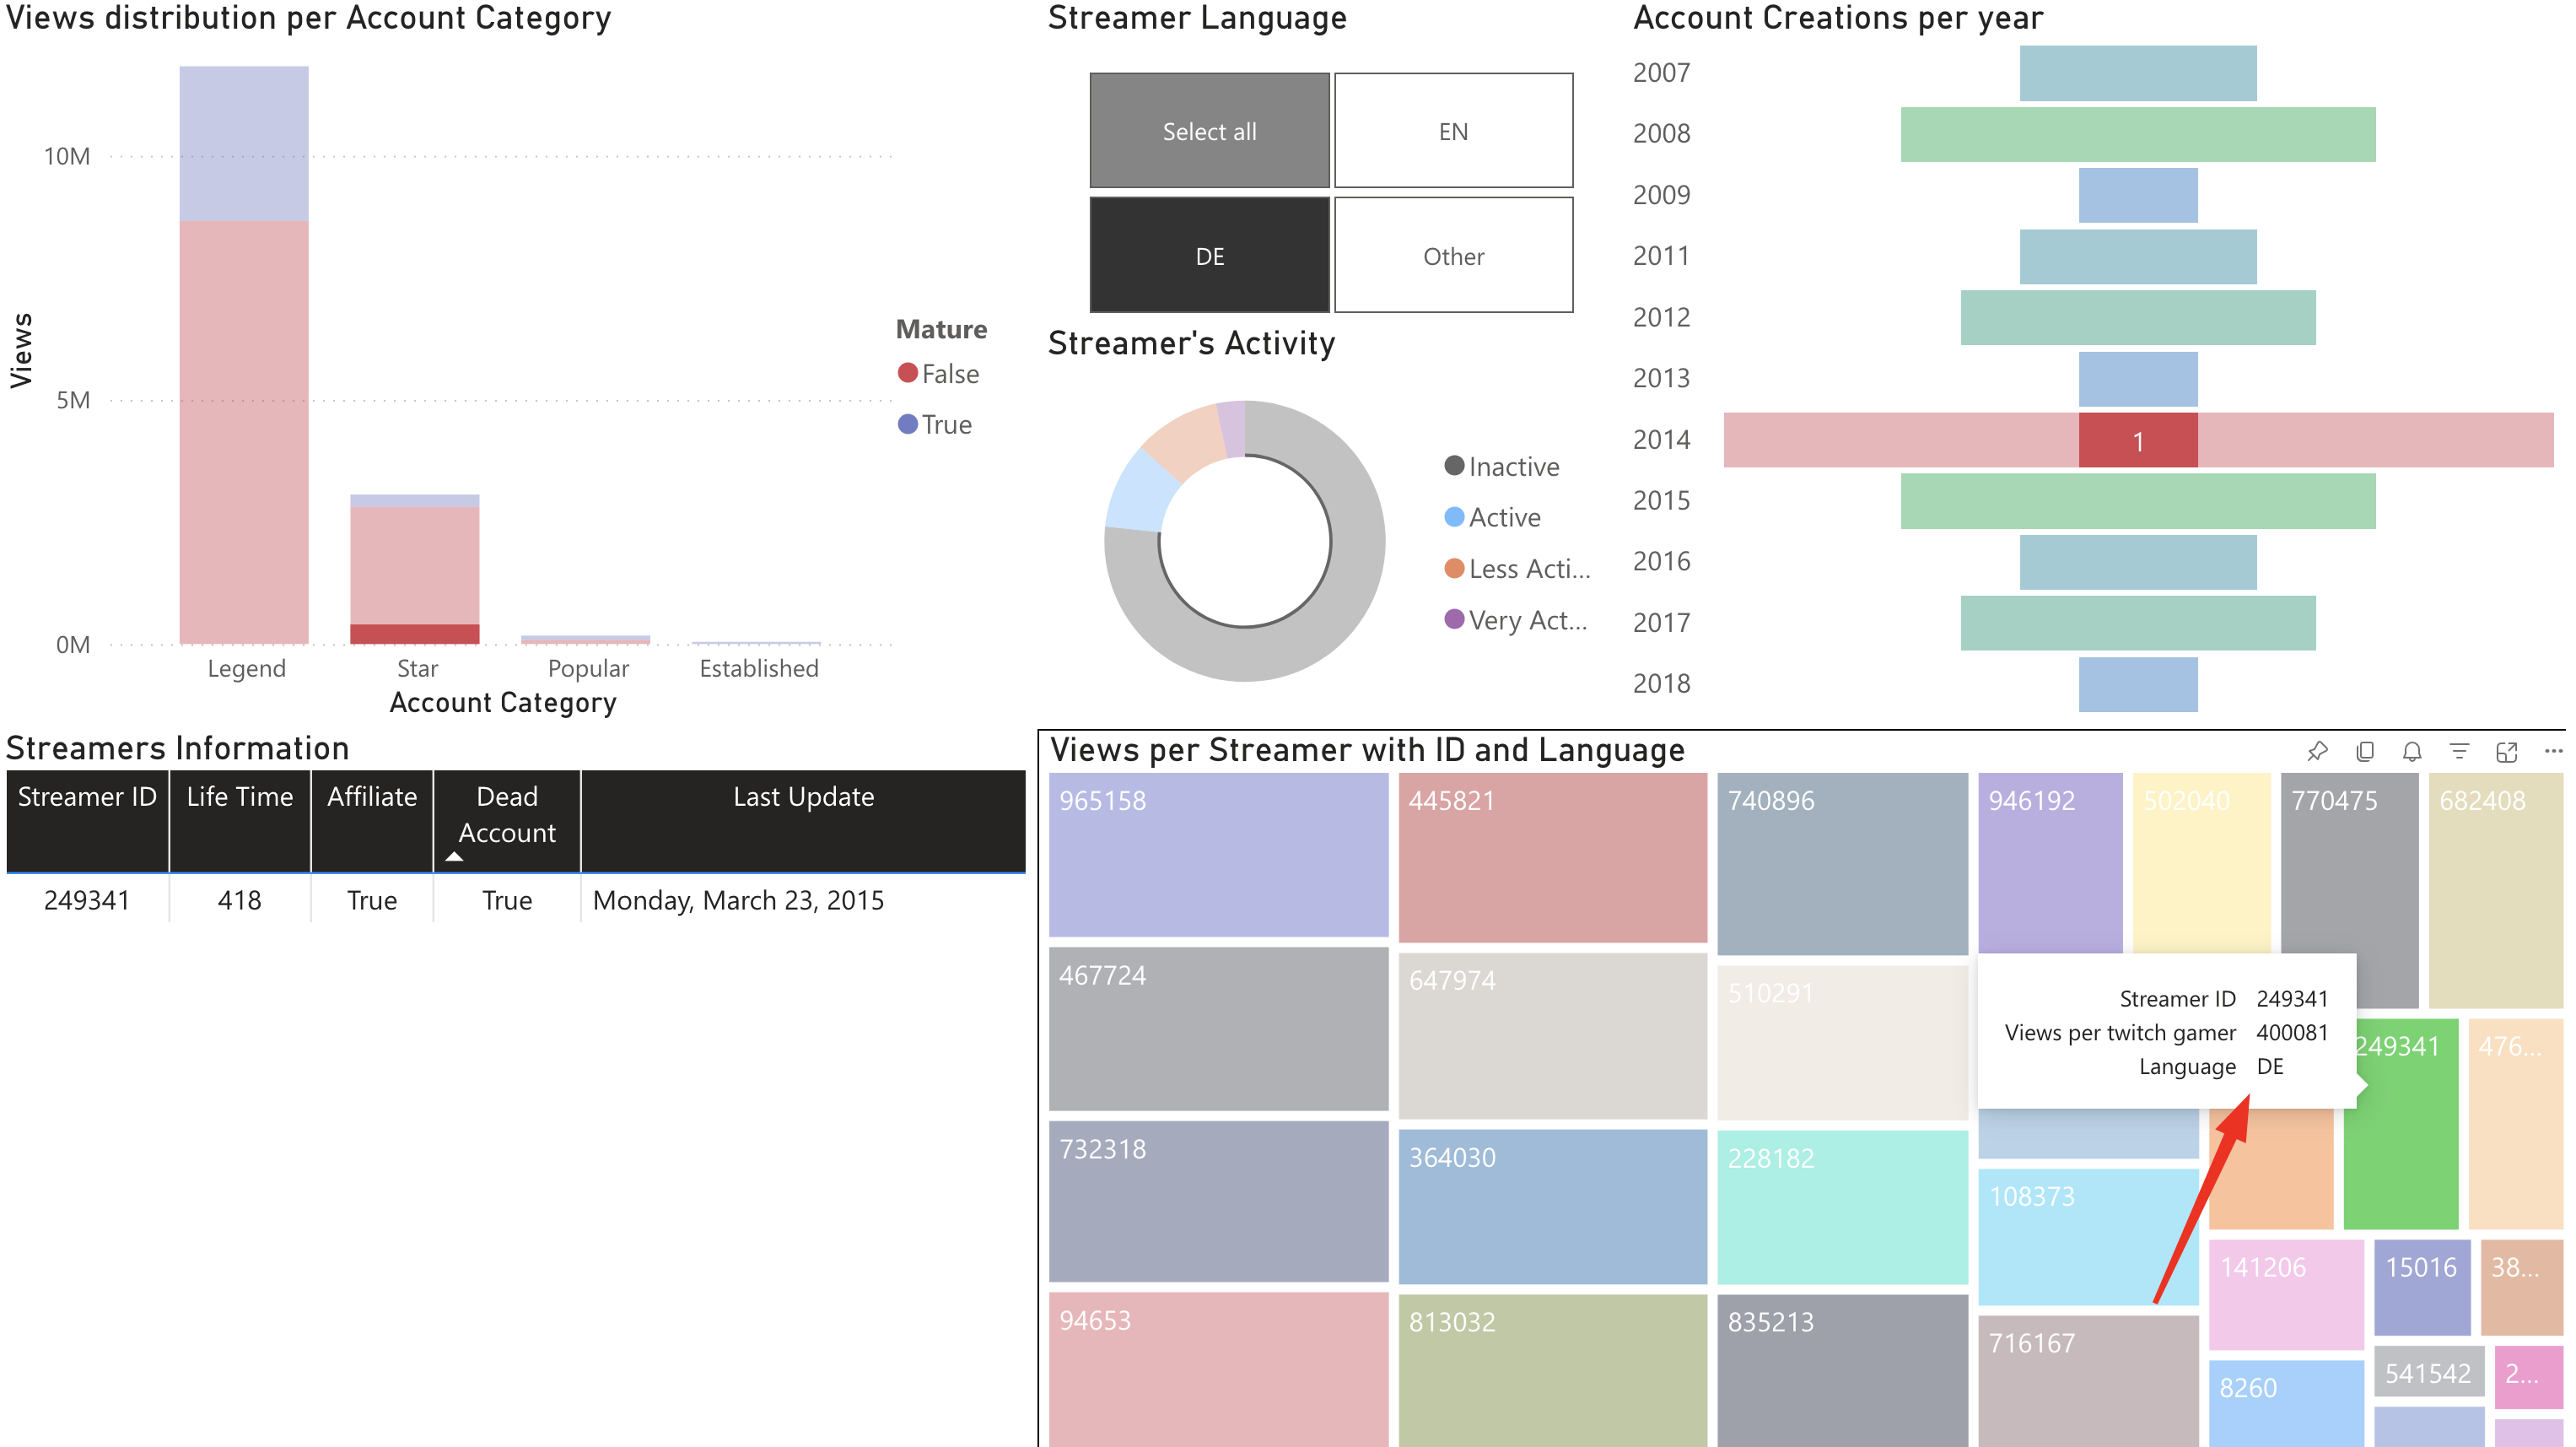